# GoEmotions: A Fine-Grained Multi-Label Emotion Classifier
# Project Overview

This notebook details a capstone project focused on building a multi-label emotion classification system. The primary goal is to predict one or more of 28 distinct emotion labels from a given Reddit comment. This project navigates key challenges of the task, including class imbalance and the multi-label nature of the data, to build a high-performing deep learning model

### 1. Setup and Data Loading
We begin by importing the necessary Python libraries. These libraries are used for data manipulation, visualization, text processing, and deep learning model building.

In [1]:
!pip install pandas pyarrow nltk emoji numpy matplotlib seaborn wordcloud


Next, we load the pre-split GoEmotions dataset. This dataset is sourced from Reddit and has been carefully annotated by human raters with fine-grained emotion labels. We perform an initial check on the dataset splits to verify their size and structure.

In [2]:
import pandas as pd
import nltk
import re
import emoji
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

nltk.download('punkt')
nltk.download('wordnet')

# Load the Simplified Splits
splits = {
    'train':      'simplified/train-00000-of-00001.parquet',
    'validation': 'simplified/validation-00000-of-00001.parquet',
    'test':       'simplified/test-00000-of-00001.parquet'
}
base = "hf://datasets/google-research-datasets/go_emotions/"

df_train = pd.read_parquet(base + splits['train'])
df_val   = pd.read_parquet(base + splits['validation'])
df_test  = pd.read_parquet(base + splits['test'])

print("Train examples:", len(df_train))
print("Validation examples:", len(df_val))
print("Test examples:", len(df_test))
df_train.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raulflores/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/raulflores/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/miniconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train examples: 43410
Validation examples: 5426
Test examples: 5427


,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


### 2. Exploratory Data Analysis (EDA)
Data exploration is a critical step in understanding the unique challenges of the GoEmotions dataset. The findings here will inform our model's design, particularly the choice of evaluation metrics and loss function.

### 2.1 Label Cardinality & Distribution
First, we examine label cardinality, which is the number of emotions assigned to a single comment. The dataset is multi-label, and this analysis reveals that while most comments have a single label, a notable portion has two or more.

In [3]:
card = df_train['labels'].map(len)
print("Label Cardinality:")
print(card.value_counts().sort_index())

val_card = df_val['labels'].map(len)
print("\nLabel Cardinality in Validation Set:")
print(val_card.value_counts().sort_index())

test_card = df_test['labels'].map(len)
print("\nLabel Cardinality in Test Set:")
print(test_card.value_counts().sort_index())



Label Cardinality:
labels
1    36308
2     6541
3      532
4       28
5        1
Name: count, dtype: int64

Label Cardinality in Validation Set:
labels
1    4548
2     809
3      62
4       7
Name: count, dtype: int64

Label Cardinality in Test Set:
labels
1    4590
2     774
3      61
4       2
Name: count, dtype: int64


Next, we visualize the frequency of each emotion. The bar chart clearly shows a severe class imbalance. Emotions like admiration and gratitude are very common, while others like grief and pride are rare. This finding is critical for our modeling approach, as it necessitates the use of a specialized loss function like Focal Loss to prevent the model from ignoring the less frequent emotions.

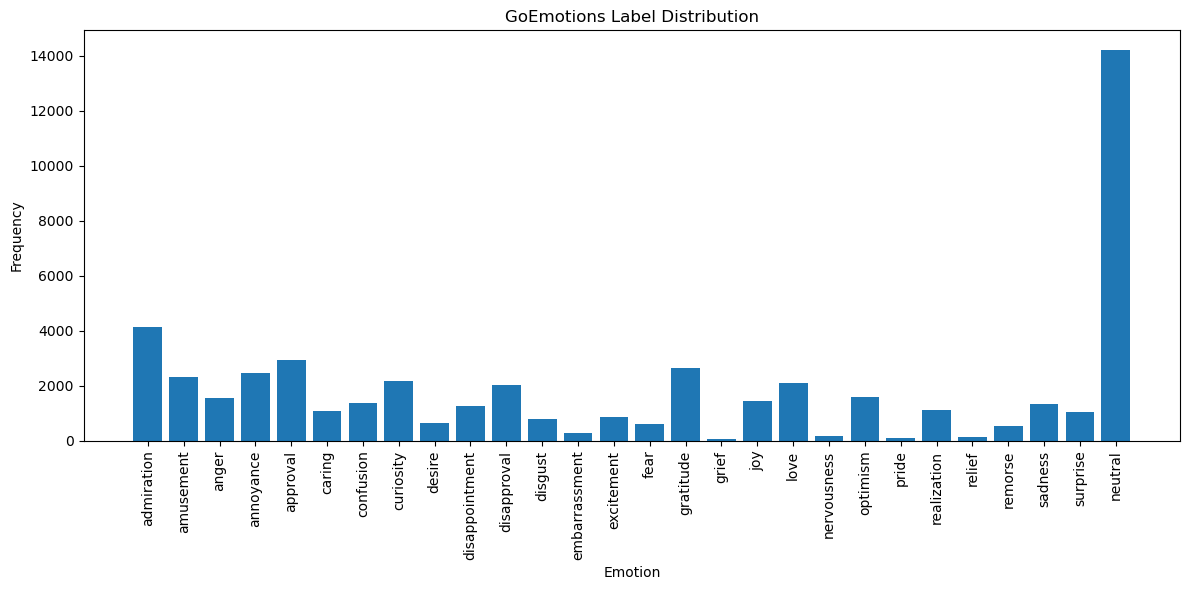

In [4]:
emotion_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

all_labels = [lbl for labels in df_train['labels'] for lbl in labels]
freq = Counter(all_labels)
counts = [freq[i] for i in range(len(emotion_labels))]

plt.figure(figsize=(12, 6))
plt.bar(emotion_labels, counts)
plt.xticks(rotation=90)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('GoEmotions Label Distribution')
plt.tight_layout()
plt.show()

For a higher-level view, we can group the 28 fine-grained emotions into broader sentiment categories: positive, negative, and ambiguous. This provides a simplified perspective on the overall emotional tone of the dataset.

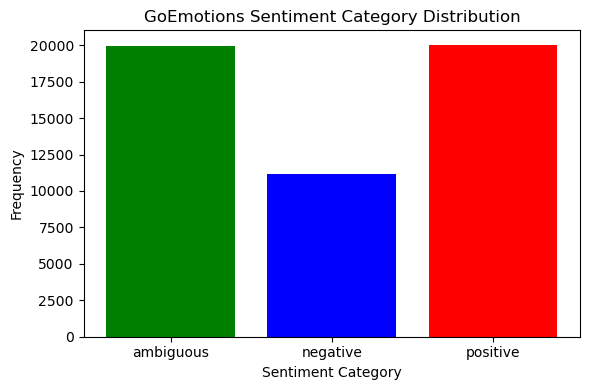

In [5]:
# Categorize emotions
positive = {
    'admiration', 'amusement', 'approval', 'caring', 'excitement', 'gratitude',
    'joy', 'love', 'optimism', 'pride', 'relief', 'desire'
}
negative = {
    'anger', 'annoyance', 'disappointment', 'disapproval', 'disgust',
    'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness'
}
ambiguous = {
    'confusion', 'curiosity', 'realization', 'surprise', 'neutral'
}

# Build a map from label index to category
label_to_category = {}
for idx, label in enumerate(emotion_labels):
    if label in positive:
        label_to_category[idx] = 'positive'
    elif label in negative:
        label_to_category[idx] = 'negative'
    else:
        label_to_category[idx] = 'ambiguous'

# Count category frequencies
category_counts = Counter()
for labels in df_train['labels']:
    for lbl in labels:
        category = label_to_category[lbl]
        category_counts[category] += 1

# Plot
plt.figure(figsize=(6, 4))
plt.bar(category_counts.keys(), category_counts.values(), color=['green', 'blue', 'red'])
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.title('GoEmotions Sentiment Category Distribution')
plt.tight_layout()
plt.show()

Finally, we analyze co-occurring emotion combinations to understand the relationships between the labels. This is a key feature of a multi-label dataset and can provide insights for more advanced models.

In [6]:
# Get comments with multiple labels
multi_label_comments = df_train[df_train['labels'].apply(len) > 1]

# Analyze co-occurring emotions (for comments with more than one label)
co_occurrence = Counter()
for labels in multi_label_comments['labels']:
    # Sort labels to count combinations uniquely
    sorted_labels = tuple(sorted(labels))
    co_occurrence[sorted_labels] += 1

print("Most common co-occurring emotion combinations:")
# Map label indices back to emotion names for readability
most_common_co_occurrences = co_occurrence.most_common(20)
for combo, count in most_common_co_occurrences:
    emotion_combo = [emotion_labels[i] for i in combo]
    print(f"{emotion_combo}: {count}")

Most common co-occurring emotion combinations:
['anger', 'annoyance']: 230
['admiration', 'gratitude']: 227
['admiration', 'approval']: 199
['approval', 'neutral']: 190
['confusion', 'curiosity']: 174
['admiration', 'love']: 155
['annoyance', 'disapproval']: 148
['annoyance', 'neutral']: 123
['disapproval', 'neutral']: 104
['disappointment', 'sadness']: 103
['curiosity', 'neutral']: 102
['admiration', 'joy']: 92
['admiration', 'neutral']: 90
['confusion', 'neutral']: 83
['annoyance', 'disappointment']: 79
['admiration', 'optimism']: 79
['admiration', 'amusement']: 72
['realization', 'neutral']: 71
['approval', 'optimism']: 71
['amusement', 'joy']: 69


### 2.2 Text Characteristics & Cleaning Needs
Examining the text's properties helps us design a robust preprocessing pipeline. We analyze the distribution of text lengths and identify the presence of placeholders and non-ASCII characters, which are forms of noise in the data.

String length (chars) stats:
count    43410.000000
mean        68.400875
std         36.721898
min          2.000000
25%         38.000000
50%         65.000000
75%         96.000000
95%        131.000000
max        703.000000
Name: stringlengths, dtype: float64

[NAME] placeholders: 6059
Comments with non‑ASCII chars: 6390


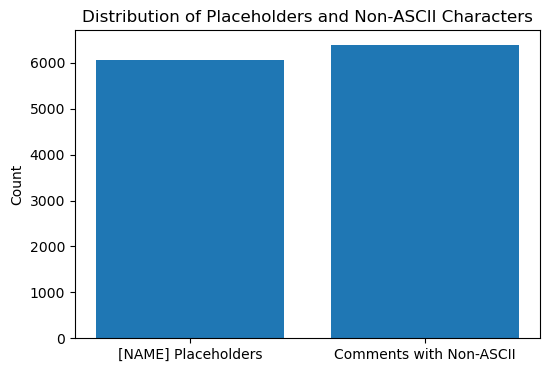

In [7]:
print("String length (chars) stats:")
df_train['stringlengths'] = df_train['text'].str.len()
print(df_train['stringlengths'].describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

name_placeholder_count = df_train['text'].str.contains(r'\[NAME\]').sum()
non_ascii_count = df_train['text'].str.contains(r'[^\x00-\x7F]').sum()

print(f"\n[NAME] placeholders: {name_placeholder_count}")
print(f"Comments with non‑ASCII chars: {non_ascii_count}")

labels = ['[NAME] Placeholders', 'Comments with Non-ASCII']
counts = [name_placeholder_count, non_ascii_count]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.ylabel('Count')
plt.title('Distribution of Placeholders and Non-ASCII Characters')
plt.show()

### 3. Preprocessing and Tokenization
Based on our EDA findings, we create a cleaning and tokenization pipeline. This prepares the raw text for a GloVe-based model by standardizing contractions, handling emojis, removing noise, and lemmatizing words to their base form. Below is a summary of the functions we'll use for this process.

In [ ]:
import re, emoji
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def get_emoji_map(df):
    all_nonascii = df['text'].str.findall(r'[^\\x00-\\x7F]').explode().dropna()
    all_emojis   = [ch for ch in all_nonascii if ch in emoji.EMOJI_DATA]
    top_50       = [emo for emo, _ in Counter(all_emojis).most_common(50)]

    emoji_map = {}
    for emo in top_50:
        desc = emoji.demojize(emo).strip(':').replace('/', '_')
        emoji_map[emo] = f" {desc}_emoji "
    return emoji_map

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def clean_and_tokenize(text):
    # 1) Placeholder & HTML
    text = text.replace('[NAME]', ' name_token ')
    text = re.sub(r'<[^>]+>', ' ', text)

    # 2) Standardize contractions
    for patt, repl in {
        r"\bI'm\b": "i 'm", r"\bit's\b": "it 's", r"\bcan't\b": "ca n't",
        r"\bdon't\b": "do n't", r"\bthey're\b": "they 're"
    }.items():
        text = re.sub(patt, repl, text, flags=re.IGNORECASE)

    # 3) Handle hashtags & handles
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'@\w+', ' user_token ', text)

    # 4) Map or preserve emoticons/emojis
    for emo, tok in emoji_map.items():
        text = text.replace(emo, f' {tok} ')

    # 5) Remove non-ASCII, collapse repeats
    text = re.sub(r'[^\x00-\x7F]', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # 6) Lowercase & strip unwanted
    text = text.lower()
    text = re.sub(r"[^a-z'\s_#@]", ' ', text)

    # 7) Tokenize & lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t, pos='v') if t.isalpha() else t for t in tokens]

    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/raulflores/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()
emoji_map = get_emoji_map(df_train)

df_train['tokens'] = df_train['text'].map(lambda x: clean_and_tokenize(x))
df_val  ['tokens'] = df_val  ['text'].map(lambda x: clean_and_tokenize(x))
df_test ['tokens'] = df_test ['text'].map(lambda x: clean_and_tokenize(x))

print("Example tokens:", df_train.loc[0, 'tokens'])
print("Average token count (train):", df_train['tokens'].map(len).mean())
print("75th-percentile token count:", df_train['tokens'].map(len).quantile(0.75))

# Visual Check – Before vs After (10 samples)
comparison_df = df_train[['text', 'tokens']].sample(10, random_state=42)
for i, row in comparison_df.iterrows():
    print(f"\nOriginal ({i}): {row['text']}")
    print(f"Cleaned+Lemmatized ({i}): {row['tokens']}")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/raulflores/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Example tokens: ['my', 'favourite', 'food', 'be', 'anything', 'i', 'do', "n't", 'have', 'to', 'cook', 'myself']
Average token count (train): 13.270513706519235
75th-percentile token count: 19.0

Original (25759): The only way this works is if [NAME] is doing the Bird Box challenge and cant see the terms of the contract.
Cleaned+Lemmatized (25759): ['the', 'only', 'way', 'this', 'work', 'be', 'if', 'name_token', 'be', 'do', 'the', 'bird', 'box', 'challenge', 'and', 'cant', 'see', 'the', 'term', 'of', 'the', 'contract']

Original (22531): Access should be hindered it's getting destroyed.
Cleaned+Lemmatized (22531): ['access', 'should', 'be', 'hinder', 'it', "'s", 'get', 'destroy']

Original (18418): Totally fair. All I was trying to remind everyone is don't fall in love with your crushes.
Cleaned+Lemmatized (18418): ['totally', 'fair', 'all', 'i', 'be', 'try', 'to', 'remind', 'everyone', 'be', 'do', "n't", 'fall', 'in', 'love', 'with', 'your', 'crush']

Original (31117): I'm poly and jn 

We can also use word clouds to visually inspect the most common words associated with each sentiment category. This provides qualitative insights into the dataset

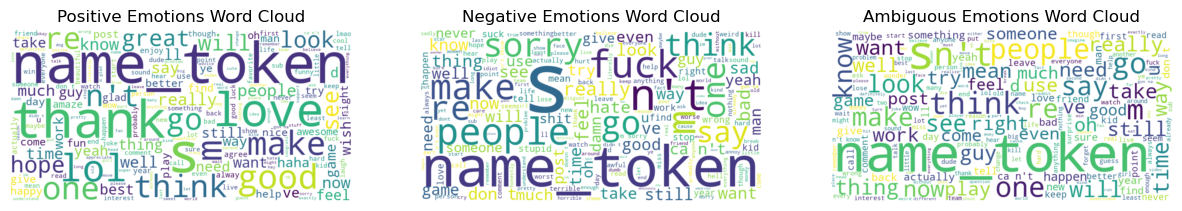

In [10]:
from wordcloud import WordCloud

# Combine tokens for each sentiment category
positive_tokens = [token for tokens in df_train[df_train['labels'].apply(lambda x: any(label_to_category[lbl] == 'positive' for lbl in x))]['tokens'] for token in tokens]
negative_tokens = [token for tokens in df_train[df_train['labels'].apply(lambda x: any(label_to_category[lbl] == 'negative' for lbl in x))]['tokens'] for token in tokens]
ambiguous_tokens = [token for tokens in df_train[df_train['labels'].apply(lambda x: any(label_to_category[lbl] == 'ambiguous' for lbl in x))]['tokens'] for token in tokens]

# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(" ".join(positive_tokens))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(" ".join(negative_tokens))
wordcloud_ambiguous = WordCloud(width=800, height=400, background_color='white').generate(" ".join(ambiguous_tokens))

# Display the word clouds
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Emotions Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Emotions Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_ambiguous, interpolation='bilinear')
plt.title('Ambiguous Emotions Word Cloud')
plt.axis('off')

plt.show()